In [32]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
import sklearn.metrics as metrics
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as pyplot
from numpy import where

In [2]:
#loading the filse
flights = pd.read_csv('data/flights.csv')
flights = flights[['fl_date','mkt_carrier','origin','dest'
                  ,'taxi_out','taxi_in','cancelled','crs_elapsed_time','arr_delay']]

#features and target
X = flights.loc[:,flights.columns!='cancelled']
y = flights[['cancelled']]

In [3]:
#lets create year, month and day
X['fl_date'] = pd.to_datetime(X['fl_date'],format='%Y-%m-%d')
X['year'] = pd.DatetimeIndex(X['fl_date']).year
X['month'] = pd.DatetimeIndex(X['fl_date']).month
X['day'] = pd.DatetimeIndex(X['fl_date']).day

In [4]:
X = X[['month','day','origin','dest','crs_elapsed_time']]

In [5]:
X= pd.get_dummies(X,columns=['origin','dest'])

In [6]:
#calculating the weights of class 0 to 1
class_0 = y.loc[y['cancelled'] == 0].value_counts().values[0]
class_1 = y.loc[y['cancelled'] == 1].value_counts().values[0]
weight = class_0/class_1
print('Ratio of Class 0 to Class 1:',weight)

Ratio of Class 0 to Class 1: 60.72839506172839


In [7]:
#Splitting into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

In [38]:
#giving the ratio as a weight to XGBClassifier
model = xgb.XGBClassifier(scale_pos_weight=60.72)
model.fit(X_train.values,y_train.values.reshape(1,-1)[0])
filename = 'XGBoost_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [34]:
y_pred = model.predict(X_test.values)
print('Roc_Auc Score:',roc_auc_score(y_test,y_pred))
print('accuracy score: ',accuracy_score(y_test,y_pred))
arr = confusion_matrix(y_test,y_pred)

Roc_Auc Score: 0.6553020324612396
accuracy score:  0.7326555555555555


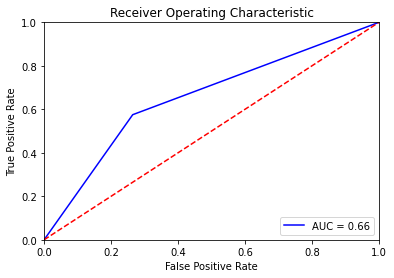

In [35]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()